In [8]:
import numpy as np
import pandas as pd


# In the previous exercises, we produced a Python function (named best_split_attribute)

In [9]:
# calculate information gain of nominal attribute
def info_gain_nominal(dataTable, attribute_nom, classLabels, attribute_class):
    # calculate the entropy of parent
    ent_p = 0
    attribute_class_list = dataTable[attribute_class].tolist()
    for e in classLabels:
        temp = attribute_class_list.count(e)
        p = temp / len(attribute_class_list)
        ent_p -= p * np.log2(p)

    # calculate the percentage of each child node, stored in dict_cp
    dict_cp = {}
    fea_values = dataTable[attribute_nom].tolist()
    for e in fea_values:
        temp = fea_values.count(e)
        p = temp / len(fea_values)
        dict_cp[e] = p

        # calculate the entropy of each child node, stored in dict_ce
    data = dataTable[[attribute_nom, attribute_class]]
    dict_ce = {}
    for e in set(fea_values):
        data_spl = data[data.iloc[:, 0] == e]
        ent = 0
        temp = data_spl.iloc[:, 1].value_counts()
        for x in temp:
            p = x / len(data_spl.iloc[:, 1])
            ent -= p * np.log2(p)
        dict_ce[e] = ent

    # calculate Information Gain
    pe = 0
    for e in dict_cp.keys():
        pe += dict_ce[e] * dict_cp[e]
    IG = ent_p - pe

    split_position = None
    return IG, split_position


# calculate information gain of numeric attribute
def info_gain_numeric(dataTable, attribute_num, classLabels, attribute_class):
    # calculate the entropy of parent
    ent_p = 0
    attribute_class_list = dataTable[attribute_class].tolist()
    for e in classLabels:
        temp = attribute_class_list.count(e)
        p = temp / len(attribute_class_list)
        ent_p -= p * np.log2(p)

    # calculate the entropy of child nodes
    attribute_num_df = dataTable[attribute_num]
    nums = sorted(list(set(attribute_num_df)))

    # find split values
    first_split_value = nums[0] - 5
    last_split_value = nums[-1] + 10
    split_value_list = [first_split_value]
    for i in range(len(nums) - 1):
        split_value = (nums[i] + nums[i + 1]) // 2
        split_value_list.append(split_value)
    split_value_list.append(last_split_value)

    # calculate the entropy of each split value
    df = dataTable[[attribute_num, attribute_class]]
    dict_spl_ent = {}  # store the entropy of each split value
    for value in split_value_list:
        df_lower = df[df[attribute_num] <= value]
        df_upper = df[df[attribute_num] > value]

        # calculate entropy
        df_lower_Defaulted_count = df_lower.iloc[:, 1].value_counts()
        ent_lower = 0
        for a in df_lower_Defaulted_count:
            p = a / len(df_lower.iloc[:, 1])
            ent_lower -= p * np.log2(p)

        df_upper_Defaulted_count = df_upper.iloc[:, 1].value_counts()
        ent_upper = 0
        for a in df_upper_Defaulted_count:
            p = a / len(df_upper.iloc[:, 1])
            ent_upper -= p * np.log2(p)

        # calculate probability
        p_lower = df_lower.shape[0] / df.shape[0]
        p_upper = df_upper.shape[0] / df.shape[0]

        # calculate overall entropy
        ent = p_lower * ent_lower + p_upper * ent_upper
        dict_spl_ent[value] = ent

    # find the split value with the lowest entropy as the split position
    ent, split_position = min(zip(dict_spl_ent.values(), dict_spl_ent.keys()))

    # calculate Information Gain
    IG = ent_p - ent
    return IG, split_position


# determine the best splitting attribute
def best_split_attribute(dataTable, attributeType, classLabels):
    # attribute type
    attribute_num_list = []
    attribute_nom_list = []
    attribute_class = None
    for key, value in attributeType.items():
        if value == 'numeric':
            attribute_num_list.append(key)
        elif value == 'nominal':
            attribute_nom_list.append(key)
        elif value == 'class':
            attribute_class = key

    # use dictionary store the attributes, information gain and split value
    info_gain_dic = {}
    split_position_dic = {}

    # nominal
    for attribute_nom in attribute_nom_list:
        if attribute_nom in dataTable.columns:
            IG, split_position = info_gain_nominal(dataTable, attribute_nom, classLabels, attribute_class)
            info_gain_dic[attribute_nom] = IG
            split_position_dic[attribute_nom] = split_position

    # numeric
    for attribute_num in attribute_num_list:
        if attribute_num in dataTable.columns:
            IG, split_position = info_gain_numeric(dataTable, attribute_num, classLabels, attribute_class)
            info_gain_dic[attribute_num] = IG
            split_position_dic[attribute_num] = split_position

    if not info_gain_dic:
        # Handle the case when no informative attributes are found
        return None, None, None

    # get the best attribute
    best_attr = max(info_gain_dic, key=info_gain_dic.get)
    best_attr_type = attributeType[best_attr]
    split_value = split_position_dic[best_attr]

    return best_attr, best_attr_type, split_value


if __name__ == '__main__':
    at1 = {'Home Owner': 'nominal', 'Marital Status': 'nominal', 'Annual Income': 'numeric', 'Defaulted': 'class'}
    cl1 = ['no', 'yes']
    df1 = pd.DataFrame(
        {
            'Home Owner': ['yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no'],
            'Marital Status': ['single', 'married', 'single', 'married', 'divorced', 'married', 'divorced', 'married',
                               'married', 'single'],
            'Annual Income': [125, 100, 70, 120, 95, 60, 220, 85, 75, 90],
            'Defaulted': ['no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes']
        }
    )
    print(f"{best_split_attribute(df1, at1, cl1)} Expected: ('Annual Income', 'numeric', '97').\n")
    df1.drop("Annual Income", axis=1, inplace=True)
    print(f"{best_split_attribute(df1, at1, cl1)} Expected: ('Home Owner', 'nominal', None).\n")
    df1.drop("Home Owner", axis=1, inplace=True)
    print(f"{best_split_attribute(df1, at1, cl1)} Expected: ('Marital Status', 'nominal', None).\n")
    print('----------------')
    cl2 = ['yes', 'dubious', 'no']
    a1 = [40, 30, 20, 50, 20, 30, 40, 60]
    a2 = ['high', 'medium', 'low', 'high', 'medium', 'low', 'low', 'low']
    a3 = ['l', 'h', 'h', 'm', 'l', 'l', 'l', 'l']
    a4 = ['divorced', 'married', 'single', 'married', 'single', 'single', 'married', 'married']
    a5 = [70, 30, 30, 20, 90, 50, 60, 20]
    a6 = ['yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no']
    cv2 = ['yes', 'no', 'no', 'no', 'yes', 'dubious', 'no', 'yes', ]
    at2 = {'a1': 'numeric', 'a2': 'nominal', 'a3': 'nominal', 'a4': 'nominal', 'a5': 'numeric', 'cc': 'class',
           'a6': 'nominal'}
    df2 = pd.DataFrame({'a1': a1, 'cc': cv2, 'a2': a2, 'a3': a3, 'a4': a4, 'a5': a5, 'a6': a6})
    print(f"{best_split_attribute(df2, at2, cl2)} Expected: ('a3', 'nominal', None).\n")
    df2.drop("a3", axis=1, inplace=True)
    print(f"{best_split_attribute(df2, at2, cl2)} Expected: ('a5', 'numeric', 65).\n")
    df2.drop("a5", axis=1, inplace=True)
    print(f"{best_split_attribute(df2, at2, cl2)} Expected: ('a4', 'nominal', None).\n")
    df2.drop("a4", axis=1, inplace=True)
    print(f"{best_split_attribute(df2, at2, cl2)} Expected: ('a1', 'numeric', 55).\n")
    df2.drop("a1", axis=1, inplace=True)
    print(f"{best_split_attribute(df2, at2, cl2)} Expected: ('a2', 'nominal', None).\n")
    df2.drop("a2", axis=1, inplace=True)
    print(f"{best_split_attribute(df2, at2, cl2)} Expected: ('a6', 'nominal', None).\n")
    print('----------------')
    cl3 = ['yes', 'dubious', 'no']
    cv3 = ['yes', 'no', 'no', 'no', 'dubious', 'dubious', 'no', 'yes', ]
    at3 = {'a1': 'numeric', 'a2': 'nominal', 'a3': 'nominal', 'a4': 'nominal', 'a5': 'numeric', 'cc': 'class',
           'a6': 'nominal'}
    df3 = pd.DataFrame({'a1': a1, 'cc': cv3, 'a2': a2, 'a3': a3, 'a4': a4, 'a5': a5, 'a6': a6})
    print(f"{best_split_attribute(df3, at3, cl3)} Expected: ('a4', 'nominal', None).\n")
    df3.drop("a4", axis=1, inplace=True)
    print(f"{best_split_attribute(df3, at3, cl3)} Expected: ('a3', 'nominal', None).\n")
    df3.drop("a3", axis=1, inplace=True)
    print(f"{best_split_attribute(df3, at3, cl3)} Expected: ('a1', 'numeric', 35).\n")
    df3.drop("a1", axis=1, inplace=True)
    print(f"{best_split_attribute(df3, at3, cl3)} Expected: ('a5', 'numeric', 40).\n")
    df3.drop("a5", axis=1, inplace=True)
    print(f"{best_split_attribute(df3, at3, cl3)} Expected: ('a2', 'nominal', None).\n")
    df3.drop("a2", axis=1, inplace=True)
    print(f"{best_split_attribute(df3, at3, cl3)} Expected: ('a6', 'nominal', None).\n")


('Annual Income', 'numeric', 97) Expected: ('Annual Income', 'numeric', '97').

('Home Owner', 'nominal', None) Expected: ('Home Owner', 'nominal', None).

('Marital Status', 'nominal', None) Expected: ('Marital Status', 'nominal', None).

----------------
('a3', 'nominal', None) Expected: ('a3', 'nominal', None).

('a5', 'numeric', 65) Expected: ('a5', 'numeric', 65).

('a4', 'nominal', None) Expected: ('a4', 'nominal', None).

('a1', 'numeric', 55) Expected: ('a1', 'numeric', 55).

('a2', 'nominal', None) Expected: ('a2', 'nominal', None).

('a6', 'nominal', None) Expected: ('a6', 'nominal', None).

----------------
('a4', 'nominal', None) Expected: ('a4', 'nominal', None).

('a3', 'nominal', None) Expected: ('a3', 'nominal', None).

('a1', 'numeric', 35) Expected: ('a1', 'numeric', 35).

('a5', 'numeric', 40) Expected: ('a5', 'numeric', 40).

('a2', 'nominal', None) Expected: ('a2', 'nominal', None).

('a6', 'nominal', None) Expected: ('a6', 'nominal', None).



# Part I Implement a decision tree training program in Python.

In [10]:
import pandas as pd
import numpy as np

class DecisionTreeNode:
    def __init__(self, attribute=None, split_value=None, class_label=None, left=None, right=None):
        self.attribute = attribute
        self.split_value = split_value
        self.class_label = class_label
        self.left = left
        self.right = right

def plurality_value(dataset, class_attribute):
    class_counts = dataset[class_attribute].value_counts()
    return class_counts.idxmax()

def decision_tree_learning(dataset, attributes, class_attribute, parent_dataset, max_depth, current_depth=0):
    if dataset.empty:
        return DecisionTreeNode(class_label=plurality_value(parent_dataset, class_attribute))
    elif len(dataset[class_attribute].unique()) == 1:
        return DecisionTreeNode(class_label=dataset[class_attribute].iloc[0])
    elif len(attributes) == 1 or current_depth == max_depth:
        return DecisionTreeNode(class_label=plurality_value(dataset, class_attribute))
    else:
        best_attribute, best_attribute_type, split_value = best_split_attribute(dataset, attributes, dataset[class_attribute].unique())

        if best_attribute is None:
            # Handle the case when no informative attributes are found
            return DecisionTreeNode(class_label=plurality_value(dataset, class_attribute))

        tree = DecisionTreeNode(attribute=best_attribute, split_value=split_value)

        if best_attribute_type == "nominal":
            for value in dataset[best_attribute].unique():
                subset = dataset[dataset[best_attribute] == value]
                new_attributes = attributes.copy()
                del new_attributes[best_attribute]
                subtree = decision_tree_learning(subset, new_attributes, class_attribute, dataset, max_depth, current_depth + 1)
                if value == list(dataset[best_attribute].unique())[0]:
                    tree.left = subtree
                else:
                    tree.right = subtree
        else:  # numeric attribute
            subset_right = dataset[dataset[best_attribute] >= split_value]
            subset_left = dataset[dataset[best_attribute] < split_value]
            tree.right = decision_tree_learning(subset_right, attributes, class_attribute, dataset, max_depth, current_depth + 1)
            tree.left = decision_tree_learning(subset_left, attributes, class_attribute, dataset, max_depth, current_depth + 1)

        return tree
# ... (include the best_split_attribute and related functions from the previous code)

def print_decision_tree(node, indent=""):
    if node.class_label is not None:
        print(f"{indent}Class: {node.class_label}")
    else:
        if isinstance(node.split_value, str):
            print(f"{indent}{node.attribute} == {node.split_value}")
        else:
            print(f"{indent}{node.attribute} >= {node.split_value}")
        print(f"{indent}Left:")
        print_decision_tree(node.left, indent + "  ")
        print(f"{indent}Right:")
        print_decision_tree(node.right, indent + "  ")

# Example usage
if __name__ == "__main__":
    # ... (include the example datasets and attribute types from the previous code)
    max_depth = 2
    class_attribute = "Defaulted"
    tree = decision_tree_learning(df1, at1, class_attribute, df1, max_depth)
    print("Decision Tree:")
    print_decision_tree(tree)

Decision Tree:
Marital Status >= None
Left:
  Class: no
Right:
  Class: yes


# Part II Evaluate decision trees

## Loading data

In [11]:
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/CDS 521 AI/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
def predict_example(tree, example):
    if tree.class_label is not None:
        return tree.class_label

    attribute_value = example[tree.attribute]
    if isinstance(tree.split_value, (int, float)):
        if attribute_value >= tree.split_value:
            return predict_example(tree.right, example)
        else:
            return predict_example(tree.left, example)
    else:
        if attribute_value == tree.split_value:
            return predict_example(tree.left, example)
        else:
            return predict_example(tree.right, example)

def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for a, p in zip(actual_labels, predicted_labels) if a == p)
    total_examples = len(actual_labels)
    accuracy = correct_predictions / total_examples
    return accuracy

def calculate_confusion_matrix(actual_labels, predicted_labels):
    unique_labels = sorted(set(actual_labels))
    num_labels = len(unique_labels)
    confusion_matrix = np.zeros((num_labels, num_labels))

    for a, p in zip(actual_labels, predicted_labels):
        a_index = unique_labels.index(a)
        p_index = unique_labels.index(p)
        confusion_matrix[a_index][p_index] += 1

    return confusion_matrix

def calculate_recall_rate(confusion_matrix):
    num_labels = confusion_matrix.shape[0]
    recall_rates = []

    for i in range(num_labels):
        true_positives = confusion_matrix[i][i]
        actual_positives = np.sum(confusion_matrix[i])
        recall_rate = true_positives / actual_positives if actual_positives != 0 else 0
        recall_rates.append(recall_rate)

    return np.array(recall_rates)

def calculate_precision_rate(confusion_matrix):
    num_labels = confusion_matrix.shape[0]
    precision_rates = []

    for i in range(num_labels):
        true_positives = confusion_matrix[i][i]
        predicted_positives = np.sum(confusion_matrix[:, i])
        precision_rate = true_positives / predicted_positives if predicted_positives != 0 else 0
        precision_rates.append(precision_rate)

    return np.array(precision_rates)

def calculate_f_measure(recall_rates, precision_rates):
    f_measures = []

    for recall, precision in zip(recall_rates, precision_rates):
        if recall + precision == 0:
            f_measure = 0
        else:
            f_measure = 2 * (recall * precision) / (recall + precision)
        f_measures.append(f_measure)

    return np.array(f_measures)



In [13]:
def split_data(dataset, num_folds):
    indices = list(range(len(dataset)))
    fold_size = len(dataset) // num_folds

    np.random.shuffle(indices)

    folds = []
    for i in range(num_folds):
        start_index = i * fold_size
        end_index = (i + 1) * fold_size if i < num_folds - 1 else len(dataset)
        fold_indices = indices[start_index:end_index]
        folds.append(fold_indices)

    return folds

def evaluate_decision_tree(dataset, attribute_types, class_attribute, max_depth, num_folds=10):
    folds = split_data(dataset, num_folds)

    accuracies = []
    confusion_matrices = []
    recall_rates = []
    precision_rates = []
    f_measures = []

    for i in range(num_folds):
        test_indices = folds[i]
        train_indices = [idx for fold in folds[:i] + folds[i+1:] for idx in fold]

        train_data = dataset.iloc[train_indices]
        test_data = dataset.iloc[test_indices]

        tree = decision_tree_learning(train_data, attribute_types, class_attribute, train_data, max_depth)

        predictions = []
        for _, row in test_data.iterrows():
            prediction = predict_example(tree, row)
            predictions.append(prediction)

        actual_labels = test_data[class_attribute].tolist()

        accuracy = calculate_accuracy(actual_labels, predictions)
        confusion_matrix = calculate_confusion_matrix(actual_labels, predictions)
        recall_rate = calculate_recall_rate(confusion_matrix)
        precision_rate = calculate_precision_rate(confusion_matrix)
        f_measure = calculate_f_measure(recall_rate, precision_rate)

        accuracies.append(accuracy)
        confusion_matrices.append(confusion_matrix)
        recall_rates.append(recall_rate)
        precision_rates.append(precision_rate)
        f_measures.append(f_measure)

    avg_accuracy = np.mean(accuracies)
    avg_confusion_matrix = np.mean(confusion_matrices, axis=0)
    avg_recall_rate = np.mean(recall_rates, axis=0)
    avg_precision_rate = np.mean(precision_rates, axis=0)
    avg_f_measure = np.mean(f_measures, axis=0)

    return avg_accuracy, avg_confusion_matrix, avg_recall_rate, avg_precision_rate, avg_f_measure

In [14]:
if __name__ == "__main__":
    df1 = pd.read_csv(data_path + 'iris.csv')
    attribute_types1 = {
        'sepal_length': 'numeric',
        'sepal_width': 'numeric',
        'petal_length': 'numeric',
        'petal_width': 'numeric',
    }
    class_attribute1 = "iris_type:class"
    max_depth1 = 4

    accuracy1, confusion_matrix1, recall_rate1, precision_rate1, f_measure1 = evaluate_decision_tree(
        df1, attribute_types1, class_attribute1, max_depth1
    )

    print("Iris Dataset:")
    print("Accuracy:", accuracy1)
    print("Confusion Matrix:\n", confusion_matrix1)
    print("Recall Rates:", recall_rate1)
    print("Precision Rates:", precision_rate1)
    print("F-Measures:", f_measure1)

    df2 = pd.read_csv(data_path + 'penguins.csv')
    attribute_types2 = {
        'island': 'nominal',
        'bill_length_mm': 'numeric',
        'bill_depth_mm': 'numeric',
        'flipper_length_mm': 'numeric',
        'body_mass_g': 'numeric',
        'sex': 'nominal',
        'year': 'nominal'
    }
    class_attribute2 = "species:class"
    max_depth2 = 5

    accuracy2, confusion_matrix2, recall_rate2, precision_rate2, f_measure2 = evaluate_decision_tree(
        df2, attribute_types2, class_attribute2, max_depth2
    )

    print("\nPenguin Dataset:")
    print("Accuracy:", accuracy2)
    print("Confusion Matrix:\n", confusion_matrix2)
    print("Recall Rates:", recall_rate2)
    print("Precision Rates:", precision_rate2)
    print("F-Measures:", f_measure2)

Iris Dataset:
Accuracy: 0.2
Confusion Matrix:
 [[1.6 1.8 1.6]
 [3.2 0.9 0.9]
 [2.7 1.8 0.5]]
Recall Rates: [0.5 0.3 0.2]
Precision Rates: [0.10666667 0.06       0.03333333]
F-Measures: [0.17337461 0.09896801 0.05686275]

Penguin Dataset:
Accuracy: 0.4408668730650155
Confusion Matrix:
 [[15.2  0.   0. ]
 [ 6.8  0.   0. ]
 [12.4  0.   0. ]]
Recall Rates: [1. 0. 0.]
Precision Rates: [0.44086687 0.         0.        ]
F-Measures: [0.60869243 0.         0.        ]


# Part III Visualize the decision tree.

In [24]:
import graphviz
from graphviz import Digraph
from sklearn.model_selection import KFold
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import os

In [38]:
def visualize_decision_tree(tree, dataset, attributes, class_attribute, label_encoders, tree_index, output_path):
    dot = Digraph(comment="Decision Tree")

    def traverse_tree(node_id, parent_node=None, branch_label=None):
        if tree.feature[node_id] == -2:  # Leaf node
            class_id = np.argmax(tree.value[node_id][0])
            class_label = dataset[class_attribute].unique()[class_id]
            dot.node(str(node_id), label=f"Class: {class_label}", shape="box")
        else:
            attribute = list(attributes.keys())[tree.feature[node_id]]
            attribute_type = attributes[attribute]
            if attribute_type == "numeric":
                threshold = tree.threshold[node_id]
                dot.node(str(node_id), label=f"{attribute} <= {threshold:.2f}?")
            else:
                le = label_encoders[attribute]
                left_value = le.inverse_transform([int(tree.threshold[node_id])])[0]
                dot.node(str(node_id), label=f"{attribute} = {left_value}?")

        if parent_node is not None:
            dot.edge(str(parent_node), str(node_id), label=branch_label)

        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]

        if left_child != -1:
            traverse_tree(left_child, node_id, branch_label="True" if attribute_type == "numeric" else "Left")
        if right_child != -1:
            traverse_tree(right_child, node_id, branch_label="False" if attribute_type == "numeric" else "Right")

    traverse_tree(0)
    # Save the dot file as a PDF
    dot.render(os.path.join(output_path, f"tree_{tree_index}"), format='pdf', cleanup=True)
    return dot

def cross_validate_and_visualize(dataset, attribute_types, class_attribute, dataset_name, num_folds=10, max_depth=5, output_path=data_path):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=12)

    decision_trees = []
    label_encoders = {}

    for column in dataset.columns:
        if column == class_attribute:
            continue
        attribute = column.split(':')[0]
        attribute_type = attribute_types[attribute]
        if attribute_type == "nominal":
            le = LabelEncoder()
            dataset[column] = le.fit_transform(dataset[column])
            label_encoders[attribute] = le

    for i, (train_indices, test_indices) in enumerate(kf.split(dataset)):
        train_data = dataset.iloc[train_indices]
        X_train = train_data.drop(class_attribute, axis=1)
        y_train = train_data[class_attribute]

        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(X_train, y_train)

        decision_trees.append(clf.tree_)

    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Visualize and save all decision trees
    for i, tree in enumerate(decision_trees):
        dot = visualize_decision_tree(tree, dataset, attribute_types, class_attribute, label_encoders, i, output_path)
        display(dot)
        print(f"Decision Tree {i+1}")
        print("="*20)

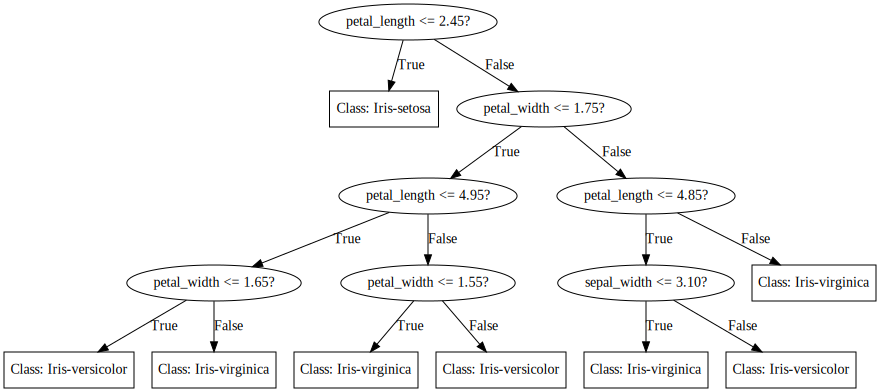

Decision Tree 1


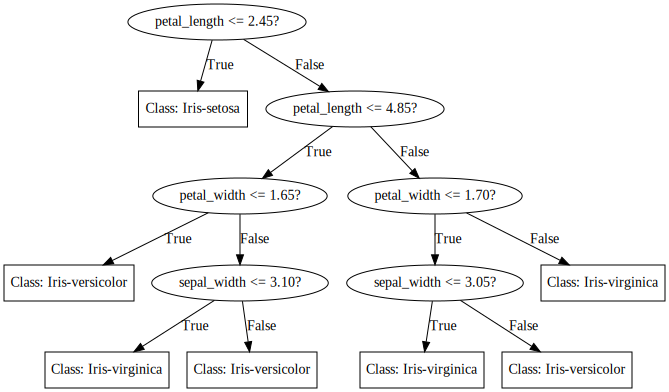

Decision Tree 2


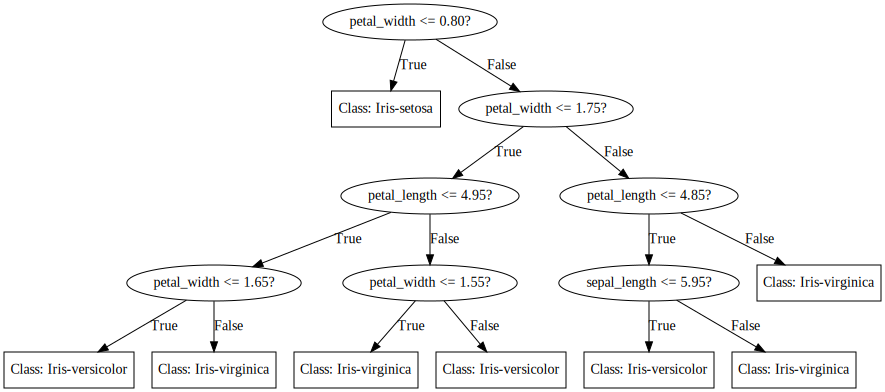

Decision Tree 3


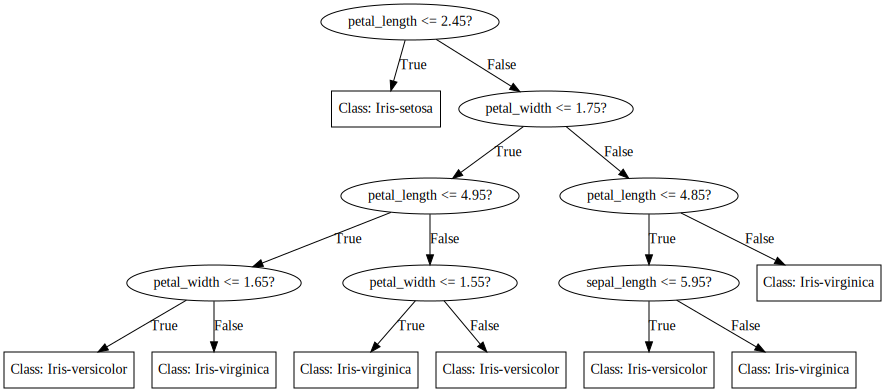

Decision Tree 4


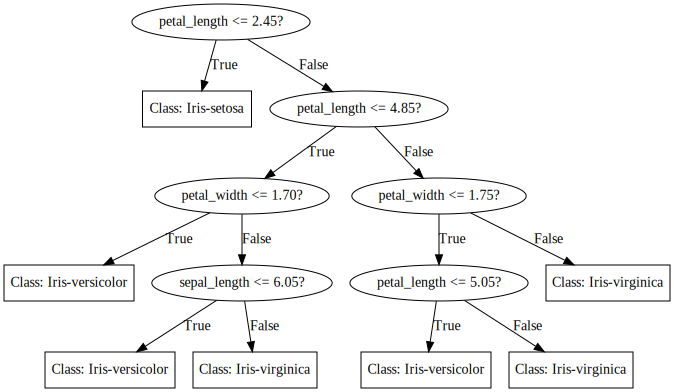

Decision Tree 5


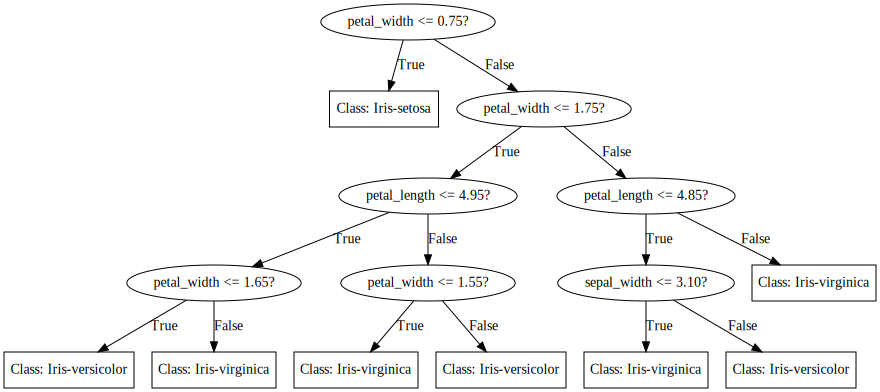

Decision Tree 6


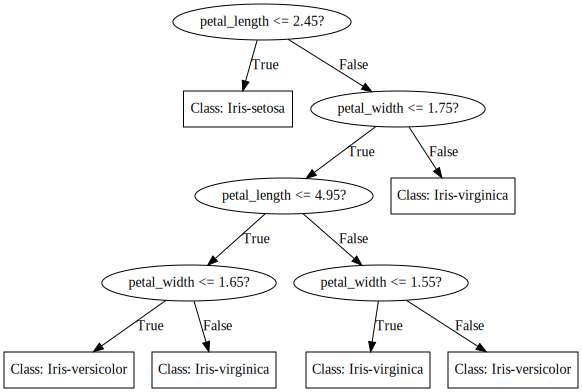

Decision Tree 7


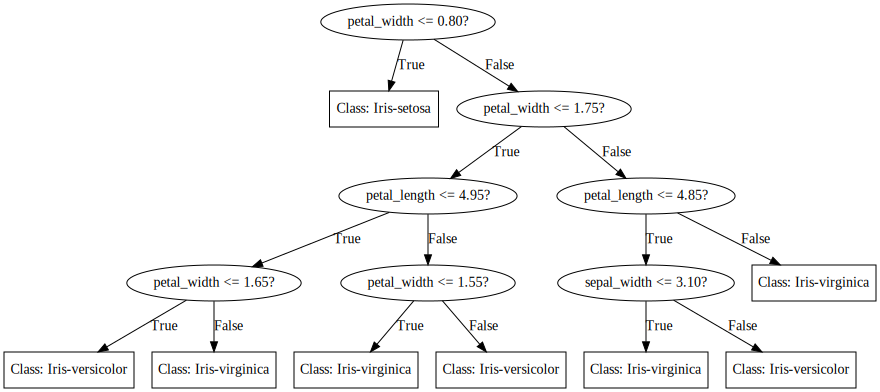

Decision Tree 8


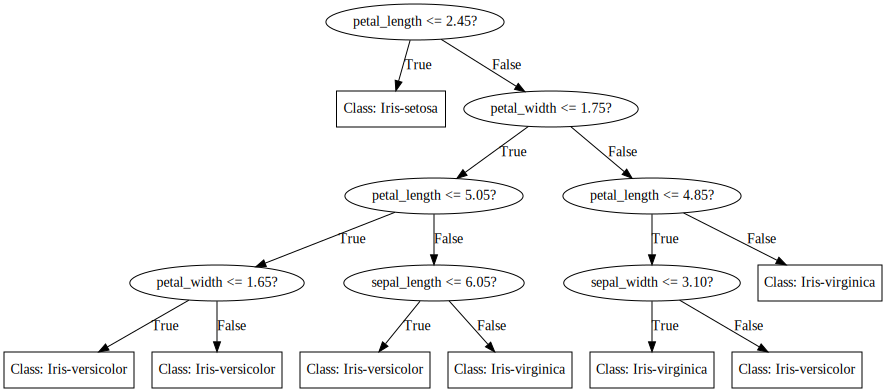

Decision Tree 9


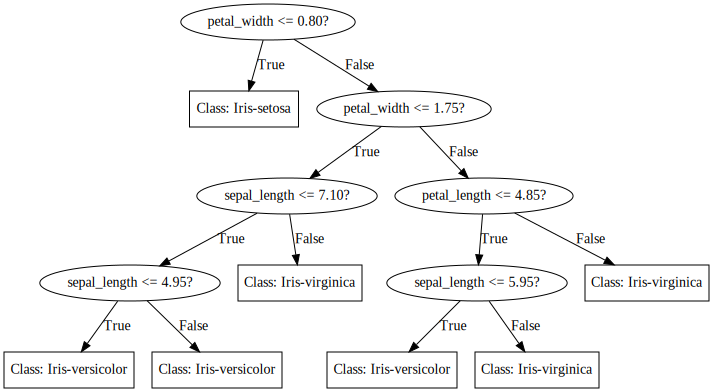

Decision Tree 10


In [41]:
attribute_types1 = {
    'sepal_length': 'numeric',
    'sepal_width': 'numeric',
    'petal_length': 'numeric',
    'petal_width': 'numeric',
}
class_attribute1 = "iris_type:class"
cross_validate_and_visualize(df1, attribute_types1, class_attribute1, "Iris", num_folds=10, max_depth=max_depth1)

In [32]:
df2.dropna(inplace=True)

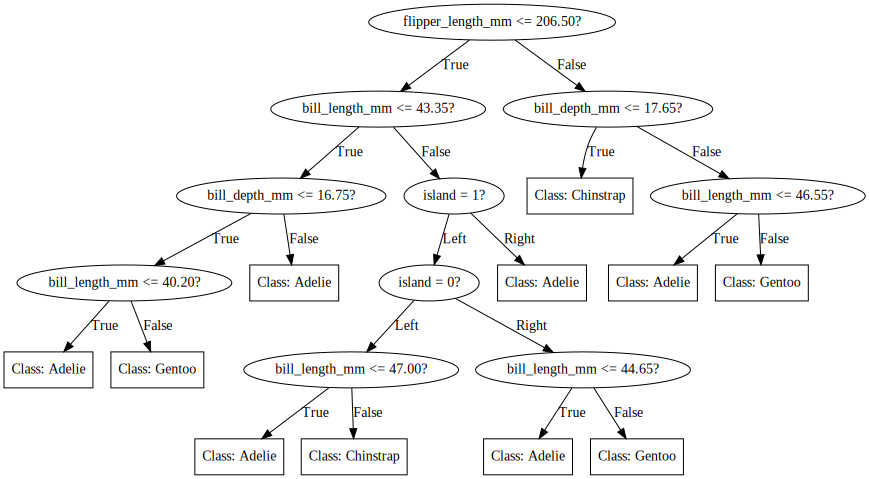

Decision Tree 1


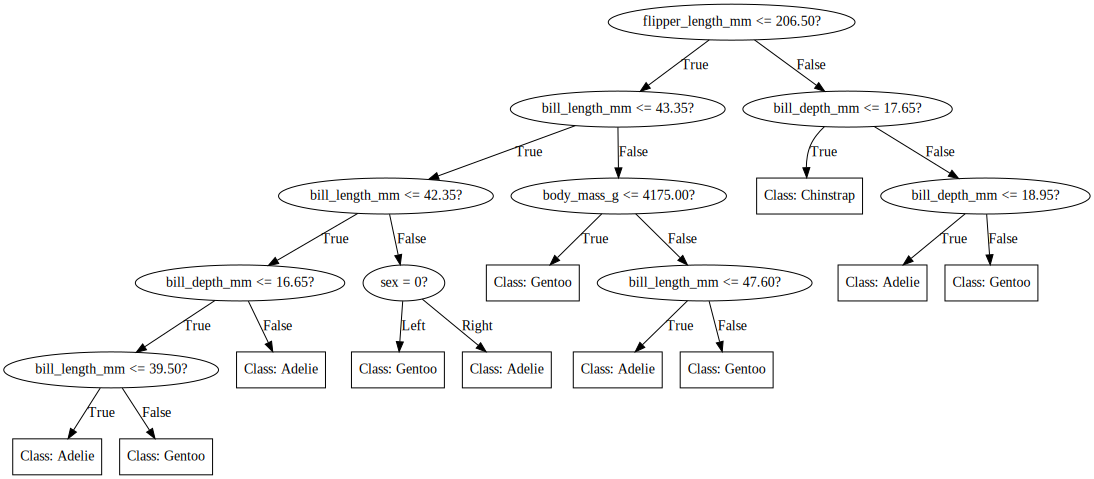

Decision Tree 2


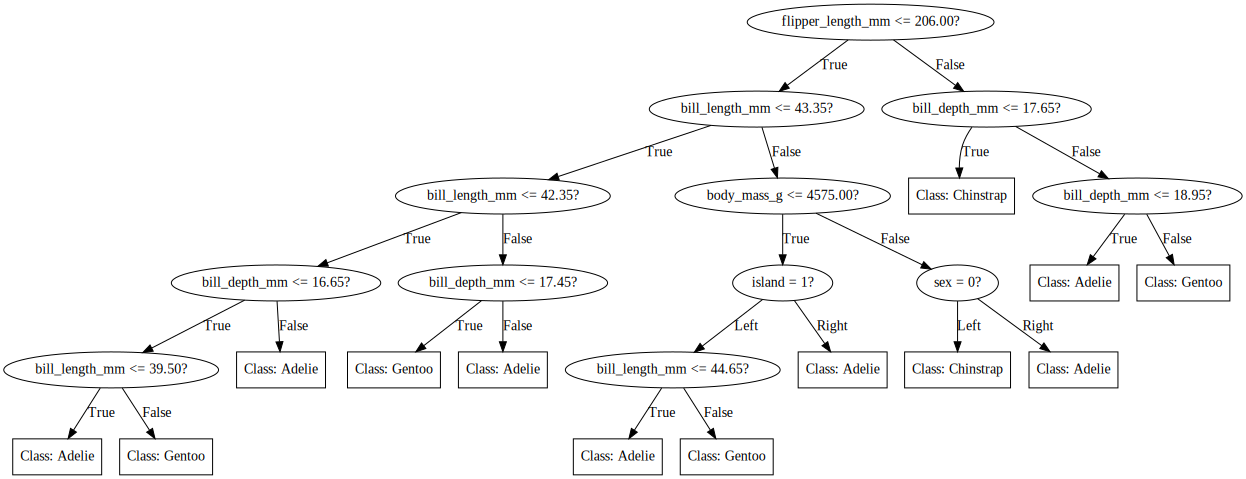

Decision Tree 3


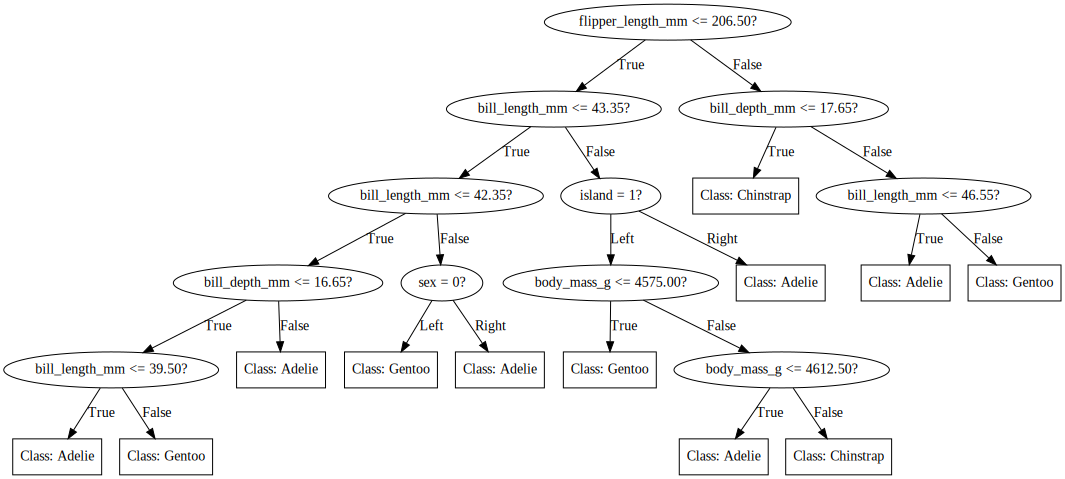

Decision Tree 4


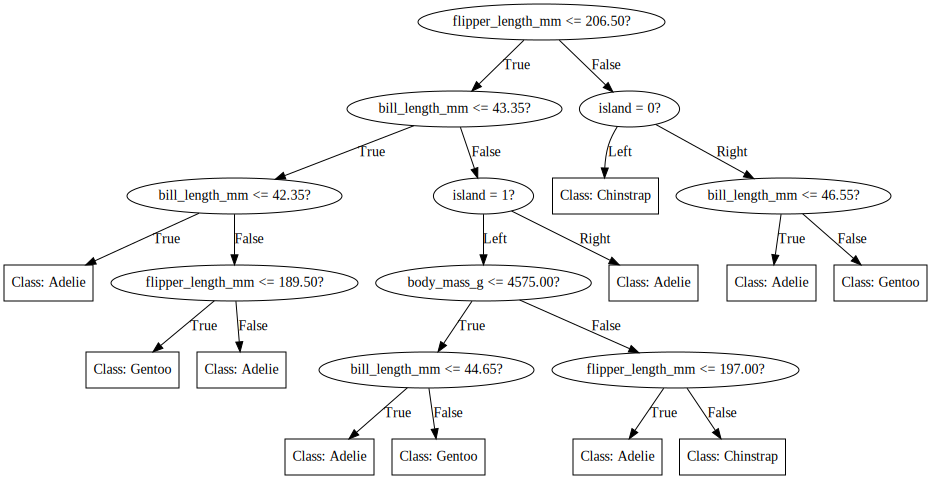

Decision Tree 5


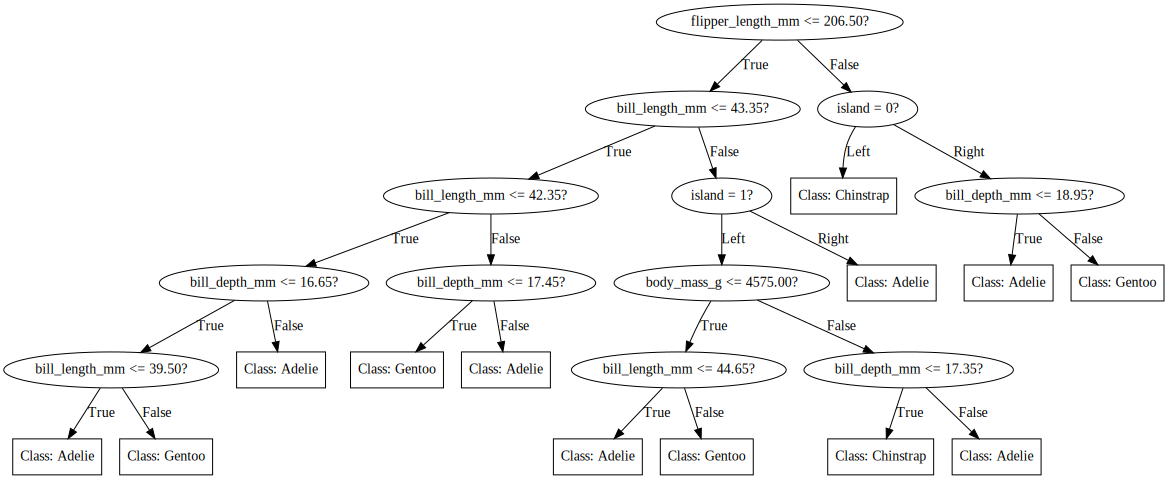

Decision Tree 6


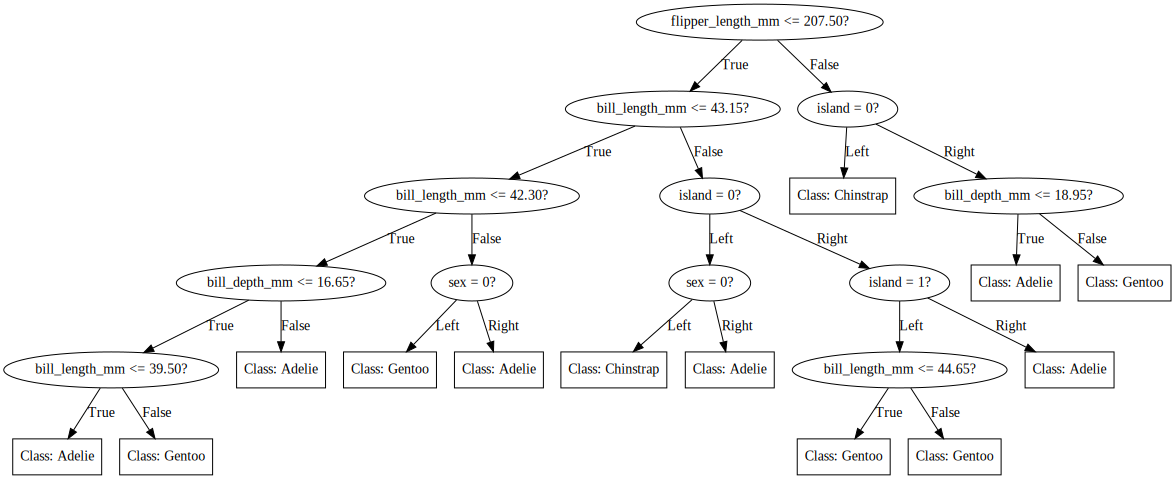

Decision Tree 7


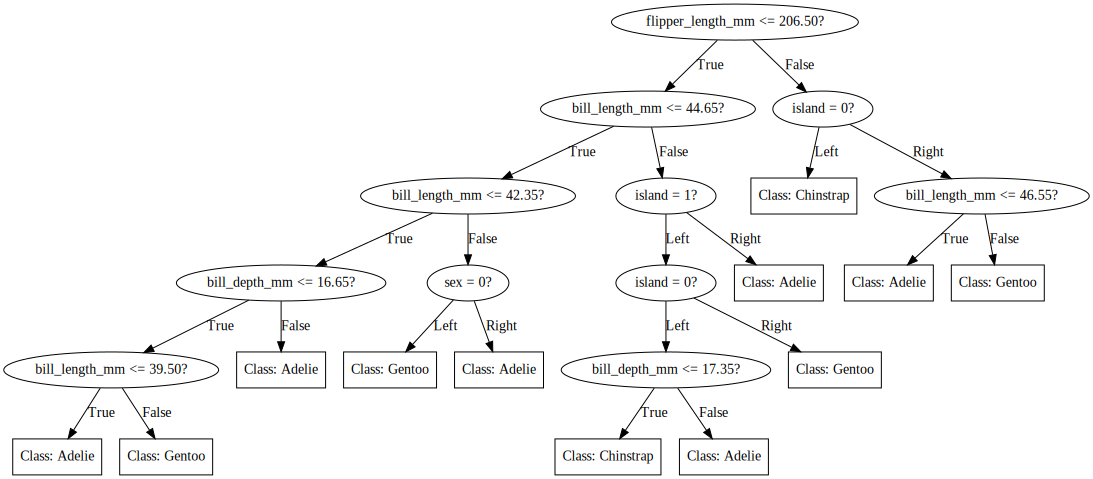

Decision Tree 8


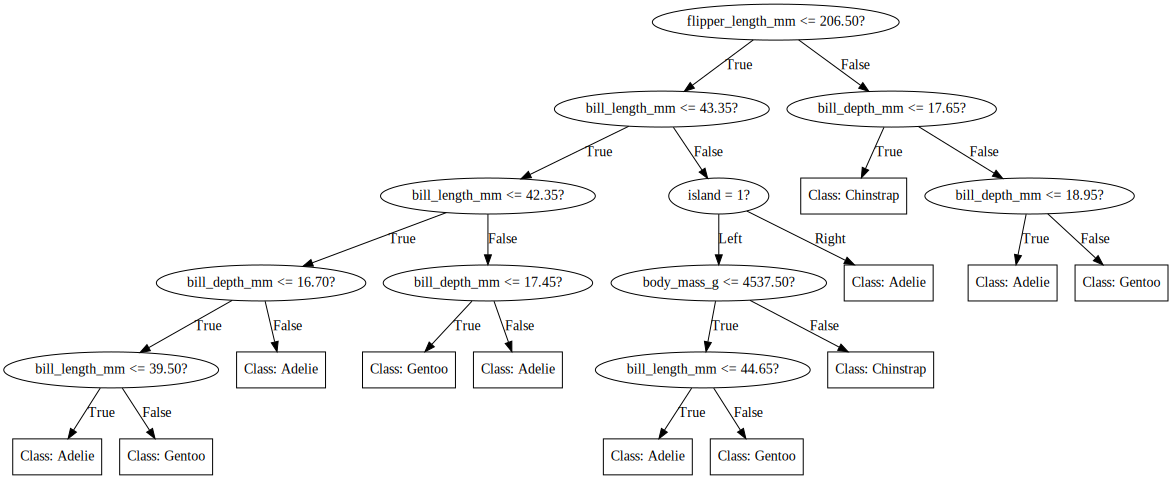

Decision Tree 9


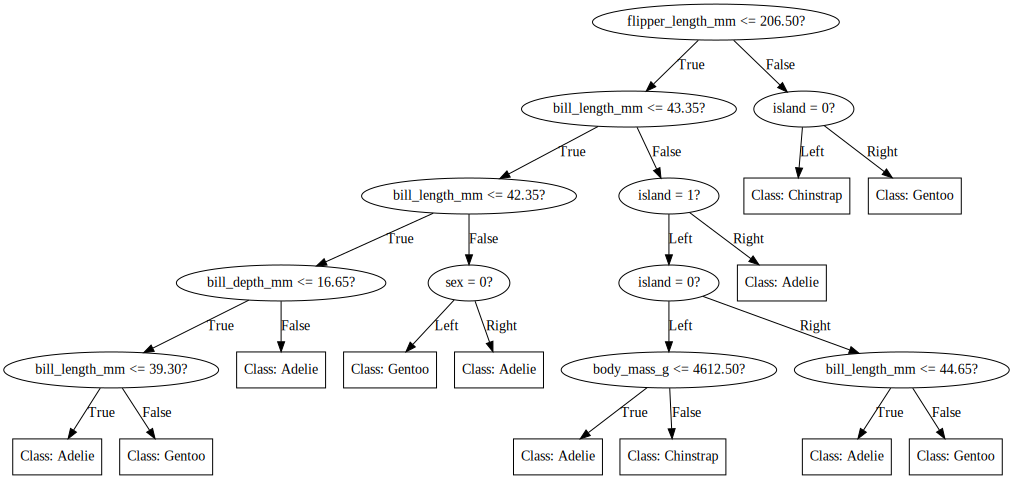

Decision Tree 10


In [40]:
attribute_types2 = {
    'island': 'nominal',
    'bill_length_mm': 'numeric',
    'bill_depth_mm': 'numeric',
    'flipper_length_mm': 'numeric',
    'body_mass_g': 'numeric',
    'sex': 'nominal',
    'year': 'nominal'
}
class_attribute2 = "species:class"

cross_validate_and_visualize(df2, attribute_types2, class_attribute2, "Penguins", num_folds=10, max_depth=max_depth2)